In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.dataset import *
from fastai.structured import *
from fastai.column_data import *

from math import ceil

from dateutil import parser

torch.cuda.set_device(0)

In [2]:
PATH = "/home/paperspace/data/dog-breed-identification/"
sz=224
arch=resnext101_64
batch_size=5

## Exploratory Analysis

In [3]:
!which python

/home/paperspace/kaggle/venv/bin/python


In [4]:
!ls {PATH}

item_categories.csv  models	      sample_submission.csv  test.csv
items.csv	     sales_train.csv  shops.csv		     tmp


In [5]:
sample_subm = pd.read_csv(f'{PATH}sample_submission.csv')
display(sample_subm.tail())

,ID,item_cnt_month
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5
214199,214199,0.5


In [6]:
item_categories = pd.read_csv(f'{PATH}item_categories.csv')
items = pd.read_csv(f'{PATH}items.csv')
shops = pd.read_csv(f'{PATH}shops.csv')
train = pd.read_csv(f'{PATH}sales_train.csv')

In [7]:
display(item_categories.head())
display(items.head())
display(shops.head())
display(train.head())

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [8]:
train['month'] = train.date.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y').month)

In [9]:
train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
2935844,10.10.2015,33,25,7409,299.0,1.0,10
2935845,09.10.2015,33,25,7460,299.0,1.0,10
2935846,14.10.2015,33,25,7459,349.0,1.0,10
2935847,22.10.2015,33,25,7440,299.0,1.0,10
2935848,03.10.2015,33,25,7460,299.0,1.0,10


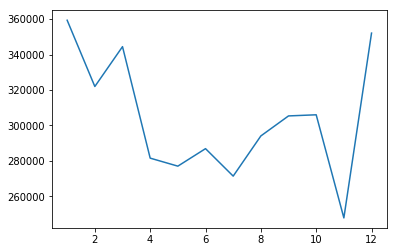

In [10]:
grouped = pd.DataFrame(train.groupby(['month'])['item_cnt_day'].sum().reset_index())
plt.plot(grouped['month'], grouped['item_cnt_day'])

In [11]:
train = train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()
train['year'] = train.date.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))

train.drop('date', axis=1)

,item_id,date_block_num,shop_id,item_price,item_cnt_day,month,item_category_id,year
0,0,20,54,58.00,1.0,9,40,2014
1,1,15,55,4490.00,1.0,4,76,2014
2,1,15,55,4490.00,1.0,4,76,2014
3,1,18,55,4490.00,1.0,7,76,2014
4,1,19,55,4490.00,1.0,8,76,2014
5,1,20,55,4490.00,1.0,9,76,2014
6,1,21,55,4490.00,1.0,10,76,2014
7,2,19,54,58.00,1.0,8,40,2014
8,2,22,54,58.00,1.0,11,40,2014
9,3,18,54,100.00,1.0,7,40,2014


In [12]:
train.head()

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,month,item_category_id,year
0,0,01.09.2014,20,54,58.0,1.0,9,40,2014
1,1,04.04.2014,15,55,4490.0,1.0,4,76,2014
2,1,02.04.2014,15,55,4490.0,1.0,4,76,2014
3,1,06.07.2014,18,55,4490.0,1.0,7,76,2014
4,1,04.08.2014,19,55,4490.0,1.0,8,76,2014


In [13]:
price = train.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price = price.sort_index()

In [14]:
train.isnull().any()

item_id             False
date                False
date_block_num      False
shop_id             False
item_price          False
item_cnt_day        False
month               False
item_category_id    False
year                False
dtype: bool

# Training

## _Deep Learning Approach_

In [64]:
cat_vars = ['item_id', 'date', 'date_block_num',
            'shop_id', 'month', 'item_category_id', 'year']
contin_vars = ['item_price', 'item_cnt_day']
dep = 'item_cnt_day'

In [65]:
train_ratio = .75
train_size = int(len(train) * train_ratio)
val_idx = list(
    np.random.choice(train.index, size=len(train)-train_size)
)

In [66]:
def rmse(y_pred, targ):
    return math.sqrt(((targ - y_pred)**2).mean())

In [67]:
for v in cat_vars:
    train[v] = train[v].astype('category').cat.as_ordered()
for v in contin_vars:
    train[v].astype('float32')

In [68]:
train.dtypes

item_id             category
date                category
date_block_num      category
shop_id             category
item_price           float64
item_cnt_day         float64
month               category
item_category_id    category
year                category
dtype: object

In [69]:
df, y, nas, mapper = proc_df(train, 'item_cnt_day', do_scale=True)

In [70]:
df.head()

,item_id,date,date_block_num,shop_id,item_price,month,item_category_id,year
0,1,26,21,55,-0.481474,9,41,2
1,2,113,16,56,2.080673,4,77,2
2,2,45,16,56,2.080673,4,77,2
3,2,190,19,56,2.080673,7,77,2
4,2,125,20,56,2.080673,8,77,2


In [71]:
md = ColumnarModelData.from_data_frame(
    path=PATH,
    val_idxs=val_idx,
    df=df,
    y=y,
    cat_flds=cat_vars,
    bs=128,
)

In [72]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]

In [73]:
cat_sz

[('item_id', 21808),
 ('date', 1035),
 ('date_block_num', 35),
 ('shop_id', 61),
 ('month', 13),
 ('item_category_id', 85),
 ('year', 4)]

In [74]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [75]:
m = md.get_learner(
    emb_szs=emb_szs,
    n_cont=len(df.columns) - len(cat_vars),
    emb_drop=.04,
    out_sz=1,
    szs=[1000, 500],
    drops=[.001, .01],
)
lr = 1e-3

In [80]:
m.lr_find()

  0%|          | 70/17863 [00:02<12:06, 24.49it/s, loss=18.1] 


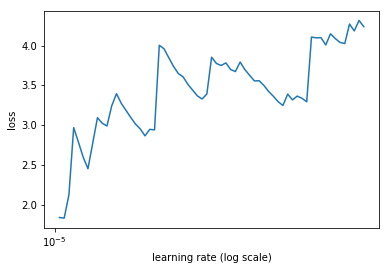

In [81]:
m.sched.plot(1)

In [ ]:
m.fit(lr, 3, metrics=[rmse])

[0.      8.01304 2.95655 0.73481]                                 
 52%|█████▏    | 9283/17863 [00:59<00:55, 155.68it/s, loss=1.71] 